In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.api.types import CategoricalDtype
import re
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
months_dtype = CategoricalDtype(categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                                            'Sep','Oct','Nov','Dec'], ordered=True)

In [3]:
# Read CSV with all data
df = pd.read_csv("finished-csvs/all-data-combined-long-format.csv", 
                 encoding="utf-8", dtype={'Month':months_dtype})
df.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
0,ASP,ASU EOP Hub,Actual Population,2009,Jan,0,df_2009_2019_melted
1,ASP,ASU Overflow,Actual Population,2009,Jan,0,df_2009_2019_melted
2,ASP,Academic Programs -\nAttendance Tracking,Average # Days in School (DIS),2009,Jan,98,df_2009_2019_melted
3,ASP,Academic Programs -\nAttendance Tracking,Average Daily Attendance,2009,Jan,663,df_2009_2019_melted
4,ASP,Academic Programs -\nAttendance Tracking,Avg. Length of Time in Assignment(LTA),2009,Jan,154,df_2009_2019_melted


In [4]:
# Filter to only high security prisons (https://www.cdcr.ca.gov/adult-operations/high-security/)
high_security = ["CAC", "CCI", "COR", "LAC", "SAC", "HDSP", "KVSP", "PBSP", "SVSP"] # omit SATF
df_highsecurity = df.loc[df['Institution'].isin(high_security)]
df_highsecurity.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1497,CCI,ASU EOP Hub,Actual Population,2009,Jan,0,df_2009_2019_melted
1498,CCI,ASU Overflow,Actual Population,2009,Jan,26,df_2009_2019_melted
1499,CCI,Academic Programs -\nAttendance Tracking,Average # Days in School (DIS),2009,Jan,74,df_2009_2019_melted
1500,CCI,Academic Programs -\nAttendance Tracking,Average Daily Attendance,2009,Jan,280,df_2009_2019_melted
1501,CCI,Academic Programs -\nAttendance Tracking,Avg. Length of Time in Assignment(LTA),2009,Jan,144,df_2009_2019_melted


In [5]:
# See how many rows are duplicates
dup = df_highsecurity[df_highsecurity.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])]

In [6]:
dup['Year'].unique()

array([2019, 2020])

In [7]:
dup['Metric Title'].unique()

array(['Medical', 'Non-Custody', 'Other Custody', 'Amphetamine Quantity',
       'Barbiturates Quantity', 'Cocaine Quantity', 'Codeine Quantity',
       'Methamphetamine Quantity', 'Morphine Quantity',
       'Synthetic Marijuana - Spice Quantity', 'Administrative RVRs',
       'Battery on a Prisoner', 'Conduct', 'Other', 'Pending RVRs',
       'Possession of Cell Phone(s)', 'Serious RVRs', 'Half Time',
       'Marijuana Quantity', 'Legal', 'Appeals Received - 1st Level',
       'Appeals Received - 2nd Level', 'Appeals Received - 3rd Level',
       'Screen Outs - 1st Level', 'Assault on a Peace Officer',
       'Assault on a Prisoner', 'Battery on a Peace Officer', 'Fighting',
       'Positive U.A.', 'Heroin Quantity', 'Appeals Denied - 2nd Level',
       'Assault with a Deadly Weapon', 'Attempted Murder',
       'Battery on a Non-Prisoner', 'Counseling RVRs',
       'Disturbance Riot or Strike', 'Sexual Disorderly Conduct',
       'Personal Property', 'Program', 'Staff Complaints',
  

In [8]:
# Some rows are repeats with errant zero values
df_highsecurity[(df_highsecurity['Year'] == 2020) & 
                (df_highsecurity['Metric Title'] == 'Documented Use of Force')].head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
2290161,CAC,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat
2290162,CAC,Number of Incidents,Documented Use of Force,2020,Jan,6,df_2020_2023_Incidents
2291996,CCI,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat
2291997,CCI,Number of Incidents,Documented Use of Force,2020,Jan,41,df_2020_2023_Incidents
2297057,COR,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat


In [9]:
# Remove 2020 Documented Use of Force with zero values from df_2020_2023_POP_no_cat file
indices_of_repeated_zero_value = df_highsecurity[(df_highsecurity['Value'] == '0') & 
                                                 (df_highsecurity['Year'] == 2020) & 
                                                 (df_highsecurity['Metric Title'] == 'Documented Use of Force') &
                                                (df_highsecurity['file'] == 'df_2020_2023_POP_no_cat')].index
df_highsecurity.drop(index=indices_of_repeated_zero_value, inplace=True)

df_highsecurity[(df_highsecurity['Year'] == 2020) & 
                (df_highsecurity['Metric Title'] == 'Documented Use of Force')].head()

/var/folders/d_/d_l8pffd5g9339qj6mktkq580000gn/T/ipykernel_95767/3027264411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highsecurity.drop(index=indices_of_repeated_zero_value, inplace=True)


,Institution,Subcategory,Metric Title,Year,Month,Value,file
2290162,CAC,Number of Incidents,Documented Use of Force,2020,Jan,6,df_2020_2023_Incidents
2291997,CCI,Number of Incidents,Documented Use of Force,2020,Jan,41,df_2020_2023_Incidents
2297058,COR,Number of Incidents,Documented Use of Force,2020,Jan,26,df_2020_2023_Incidents
2300739,HDSP,Number of Incidents,Documented Use of Force,2020,Jan,27,df_2020_2023_Incidents
2301981,KVSP,Number of Incidents,Documented Use of Force,2020,Jan,37,df_2020_2023_Incidents


In [10]:
# Extract UOF Metrics
UOF = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Documented Use of Force|Total Number of Documented Force", regex=True)]
UOF

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1825,CCI,Number of Incidents,Total Number of Documented Force,2009,Jan,12,df_2009_2019_melted
5412,COR,Number of Incidents,Total Number of Documented Force,2009,Jan,21,df_2009_2019_melted
8435,HDSP,Number of Incidents,Total Number of Documented Force,2009,Jan,30,df_2009_2019_melted
9433,KVSP,Number of Incidents,Total Number of Documented Force,2009,Jan,26,df_2009_2019_melted
9961,LAC,Number of Incidents,Total Number of Documented Force,2009,Jan,36,df_2009_2019_melted
...,...,...,...,...,...,...,...
3197168,KVSP,Number of Incidents,Documented Use of Force,2023,Oct,43,df_2020_2023_Incidents
3197237,LAC,Number of Incidents,Documented Use of Force,2023,Oct,81,df_2020_2023_Incidents
3197430,PBSP,Number of Incidents,Documented Use of Force,2023,Oct,15,df_2020_2023_Incidents
3197630,SAC,Number of Incidents,Documented Use of Force,2023,Oct,65,df_2020_2023_Incidents


In [11]:
np.sum(UOF.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])) # No UOF duplicates

0

In [12]:
POP = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Inmate Count", regex=True)]
POP

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1932,CCI,Total Bed Capacity,Inmate Count,2009,Jan,5703,df_2009_2019_melted
5519,COR,Total Bed Capacity,Inmate Count,2009,Jan,5654,df_2009_2019_melted
8542,HDSP,Total Bed Capacity,Inmate Count,2009,Jan,4415,df_2009_2019_melted
9540,KVSP,Total Bed Capacity,Inmate Count,2009,Jan,4789,df_2009_2019_melted
10068,LAC,Total Bed Capacity,Inmate Count,2009,Jan,4906,df_2009_2019_melted
...,...,...,...,...,...,...,...
3181676,KVSP,Total Bed Capacity,Inmate Count,2023,Jun,2793,df_2020_2023_POP_no_cat
3182298,LAC,Total Bed Capacity,Inmate Count,2023,Jun,2660,df_2020_2023_POP_no_cat
3184150,PBSP,Total Bed Capacity,Inmate Count,2023,Jun,1627,df_2020_2023_POP_no_cat
3186009,SAC,Total Bed Capacity,Inmate Count,2023,Jun,1759,df_2020_2023_POP_no_cat


In [13]:
np.sum(POP.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])) # No POP duplicates

0

In [14]:
# Merge the UOF extracted with POP extracted
df_merged = UOF.merge(POP, on=['Institution', 'Year', 'Month'], how='inner')
df_merged

,Institution,Subcategory_x,Metric Title_x,Year,Month,Value_x,file_x,Subcategory_y,Metric Title_y,Value_y,file_y
0,CCI,Number of Incidents,Total Number of Documented Force,2009,Jan,12,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5703,df_2009_2019_melted
1,COR,Number of Incidents,Total Number of Documented Force,2009,Jan,21,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5654,df_2009_2019_melted
2,HDSP,Number of Incidents,Total Number of Documented Force,2009,Jan,30,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4415,df_2009_2019_melted
3,KVSP,Number of Incidents,Total Number of Documented Force,2009,Jan,26,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4789,df_2009_2019_melted
4,LAC,Number of Incidents,Total Number of Documented Force,2009,Jan,36,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4906,df_2009_2019_melted
...,...,...,...,...,...,...,...,...,...,...,...
1488,KVSP,Number of Incidents,Documented Use of Force,2023,Jun,35,df_2020_2023_Incidents,Total Bed Capacity,Inmate Count,2793,df_2020_2023_POP_no_cat
1489,LAC,Number of Incidents,Documented Use of Force,2023,Jun,91,df_2020_2023_Incidents,Total Bed Capacity,Inmate Count,2660,df_2020_2023_POP_no_cat
1490,PBSP,Number of Incidents,Documented Use of Force,2023,Jun,9,df_2020_2023_Incidents,Total Bed Capacity,Inmate Count,1627,df_2020_2023_POP_no_cat
1491,SAC,Number of Incidents,Documented Use of Force,2023,Jun,47,df_2020_2023_Incidents,Total Bed Capacity,Inmate Count,1759,df_2020_2023_POP_no_cat


In [15]:
# Drop unnecessary columns
df_merged_simplified = df_merged.drop(columns=['Subcategory_x', 'file_x', 'Metric Title_x', 'Subcategory_y', 'Metric Title_y', 'file_y'])
df_merged_simplified

,Institution,Year,Month,Value_x,Value_y
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906
...,...,...,...,...,...
1488,KVSP,2023,Jun,35,2793
1489,LAC,2023,Jun,91,2660
1490,PBSP,2023,Jun,9,1627
1491,SAC,2023,Jun,47,1759


In [16]:
# Rename Value_x and Value_y to their respective sheets
df_renamed = df_merged_simplified.rename({'Value_x':'Use of Force', 
                                          'Value_y':'Inmate Count'}, axis=1)
df_renamed

,Institution,Year,Month,Use of Force,Inmate Count
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906
...,...,...,...,...,...
1488,KVSP,2023,Jun,35,2793
1489,LAC,2023,Jun,91,2660
1490,PBSP,2023,Jun,9,1627
1491,SAC,2023,Jun,47,1759


In [17]:
# Recast data types as integers for data analysis
df_UOF_rate = df_renamed.astype({'Use of Force':'Int64', 'Inmate Count':'Int64'})
df_UOF_rate.dtypes

Institution       object
Year               int64
Month           category
Use of Force       Int64
Inmate Count       Int64
dtype: object

In [18]:
# Add rate per 1000 inmates column 
df_UOF_rate['Rate'] = df_UOF_rate['Use of Force'] / df_UOF_rate['Inmate Count'] * 1000
df_UOF_rate

,Institution,Year,Month,Use of Force,Inmate Count,Rate
0,CCI,2009,Jan,12,5703,2.104156
1,COR,2009,Jan,21,5654,3.714185
2,HDSP,2009,Jan,30,4415,6.795017
3,KVSP,2009,Jan,26,4789,5.429108
4,LAC,2009,Jan,36,4906,7.337954
...,...,...,...,...,...,...
1488,KVSP,2023,Jun,35,2793,12.531328
1489,LAC,2023,Jun,91,2660,34.210526
1490,PBSP,2023,Jun,9,1627,5.531653
1491,SAC,2023,Jun,47,1759,26.719727


In [19]:
# Mean rate of each institution 
df_UOF_rate.groupby(['Institution'])['Rate'].mean()

Institution
CAC      1.648067
CCI      6.536173
COR      8.198662
HDSP     7.102604
KVSP     9.555989
LAC       11.7095
PBSP     4.978565
SAC     18.942906
SVSP    13.145545
Name: Rate, dtype: Float64

In [24]:
## Missing data for CAC
df_UOF_rate.loc[df_UOF_rate['Institution'] == 'CAC']['Year'].unique()

array([2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [20]:
# Count by institution
df_UOF_rate.groupby(['Institution']).count()

,Year,Month,Use of Force,Inmate Count,Rate
Institution,,,,,
CAC,101,101,101,101,101
CCI,174,174,174,174,174
COR,174,174,174,174,174
HDSP,174,174,174,174,174
KVSP,174,174,174,174,174
LAC,174,174,174,174,174
PBSP,174,174,174,174,174
SAC,174,174,174,174,174
SVSP,174,174,174,174,174


In [21]:
df_UOF_rate['Rate'].mean()

9.45480571203274

In [18]:
df_UOF_rate.to_csv("analysis/use_of_force.csv", encoding="utf-8", index=False)

In [27]:
df_UOF_by_year = df_UOF_rate.groupby(['Year','Institution'])['Rate'].mean().reset_index()
df_UOF_by_year.head(10)

,Year,Institution,Rate
0,2009,CCI,3.78789
1,2009,COR,3.544667
2,2009,HDSP,7.011149
3,2009,KVSP,5.403689
4,2009,LAC,6.755302
5,2009,PBSP,4.561298
6,2009,SAC,11.998722
7,2009,SVSP,9.220388
8,2010,CCI,3.519126
9,2010,COR,3.618587


In [26]:
df_pivot = df_UOF_by_year.pivot(index='Year', columns='Institution', values='Rate')
df_pivot.head(10)

Institution,CAC,CCI,COR,HDSP,KVSP,LAC,PBSP,SAC,SVSP
Year,,,,,,,,,
2009,<NA>,3.78789,3.544667,7.011149,5.403689,6.755302,4.561298,11.998722,9.220388
2010,<NA>,3.519126,3.618587,7.449524,7.89504,7.812434,4.995485,11.257568,10.319387
2011,<NA>,5.076671,5.061804,6.573171,7.783116,8.796594,5.266022,12.546238,12.918531
2012,<NA>,3.654187,5.648797,7.096301,8.740767,9.571889,6.247776,12.253709,11.556532
2013,<NA>,3.350852,5.808224,5.769188,9.077043,9.790126,6.006076,14.22398,12.029029
2014,1.592997,3.138168,6.03906,6.661476,6.951336,10.091247,2.818863,19.307105,11.262252
2015,<NA>,2.971186,6.27283,6.241873,7.375688,10.841917,3.146455,20.724475,9.986828
2016,0.392045,5.733652,8.416308,5.413288,9.431876,9.156539,4.851241,19.849676,11.425164
2017,1.064789,7.970874,12.266563,5.928961,10.533691,12.358959,4.047213,18.824785,10.486783


<Axes: xlabel='Year'>

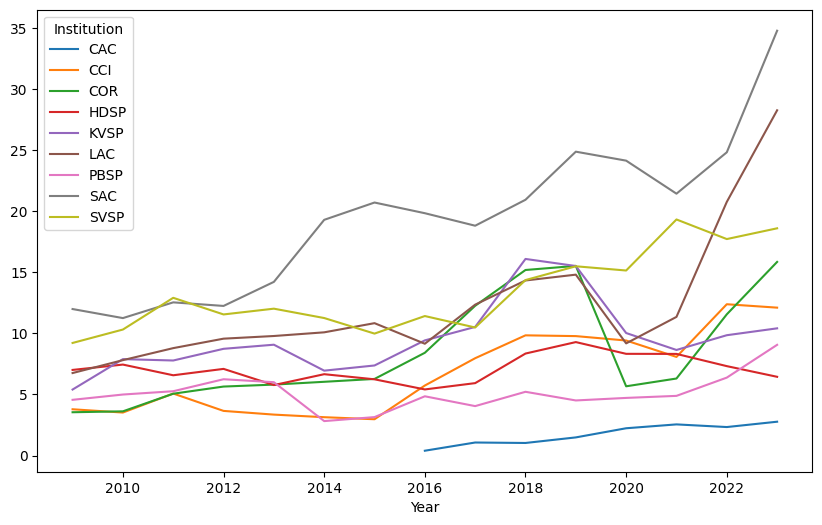

In [21]:
df_pivot.plot(figsize=(10,6))

In [25]:
df_UOF_by_month = df_UOF_rate.groupby(by=['Year','Month','Institution'])['Rate'].mean().reset_index()
df_UOF_by_month.head()

/var/folders/bs/5lqn96f965n5hzb1wwjqj37w0000gn/T/ipykernel_48933/681208034.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_UOF_by_month = df_UOF_rate.groupby(by=['Year','Month','Institution'])['Rate'].mean().reset_index()


,Year,Month,Institution,Rate
0,2009,Jan,CAC,<NA>
1,2009,Jan,CCI,2.104156
2,2009,Jan,COR,3.714185
3,2009,Jan,HDSP,6.795017
4,2009,Jan,KVSP,5.429108


In [24]:
df_UOF_by_month_pivot = df_UOF_by_month.pivot(index=['Year','Month'], columns='Institution', values='Rate')
df_UOF_by_month_pivot.head(20)

Institution   CAC       CCI       COR       HDSP      KVSP        LAC      PBSP        SAC       SVSP
Year Month                                                                                           
2009 Jan     <NA>  2.104156  3.714185   6.795017  5.429108   7.337954  3.535651  17.200675   7.045798
     Feb     <NA>  4.314995  3.595829   7.459313  4.603474   7.106599   3.55345    8.77489   8.044243
     Mar     <NA>  5.324206  3.814714   8.762076  5.418925   8.507989  5.993407   13.69863   8.174387
     Apr     <NA>  4.011461  3.257919   6.055169  4.561476   7.734807  2.678571  10.020733   8.056872
     May     <NA>  4.209721  2.586366   8.902738  7.475083   7.388092  7.491759  14.103887  10.218631
     Jun     <NA>  3.735525  2.773156   7.266122  4.014367   6.294964  4.297115  13.296011  11.396011
     Jul     <NA>  4.317323  3.685957   5.609154    6.1689   7.378472  5.564142  12.114919  10.630408
     Aug     <NA>  3.112571  3.167505   6.723442  6.599957    6.61545  4.970488   12.22067  11.646804
     Sep     <NA>  4.528828  3.989362   5.782918  5.260943    5.28653  4.361371   9.256085  10.041841
     Oct     <NA>  3.522308  4.011461   6.261181  4.424779   3.197612  2.492212  12.741047   9.840426
     Nov     <NA>  3.057065  3.375844   7.160439  5.280946   5.448997  3.591739   8.757704   5.428882
     Dec     <NA>  3.216523  4.563709   7.356219  5.606312   8.766163  6.205674   11.79941   10.12035
2010 Jan     <NA>   2.52738  2.734731    6.90577  6.672227   7.804032  6.237006   9.878169  10.829371
     Feb     <NA>  3.870099  2.900127   3.732162  7.293186   7.346586  7.464915   8.606422    9.02096
     Mar     <NA>  5.107252  3.082502   8.624502  6.644518  10.338759  3.549246  10.678608   8.224993
     Apr     <NA>  2.519315  2.067281   7.385855  5.819996   8.705114  5.102041  14.026685  14.550265
     May     <NA>  4.269126  4.390151   8.886914  6.416891    7.94702  8.433735  11.957636   7.637609
     Jun     <NA>  3.206751  2.889617  10.738255   7.97984   8.216744  3.928679  14.710913   7.182761
     Jul     <NA>  3.015075  3.259202   7.599464  9.388646    8.91886   5.78739  11.015491  11.729405
     Aug     <NA>  2.180476  5.626698   8.602651   8.44556   5.550622   4.29053   9.989666   7.506702

In [ ]:
df_UOF_by_month_pivot.plot(figsize=(15,6))